# Simulation of the $XY$ Transverse Field Ising Model with a Random $Z$ Field

We simulate the $XY$ transverse field Ising model with a random $Z$ field. 

* Our initial objective is to reproduce the results presented in Figure 4 of [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728).
* Subsequently, we utilize the ansatz based on the multi-product formula to conduct a comparative analysis for our project.

We start by importing necessary libraries etc.

In [1]:
# Importing necessary packages
# - `numpy` for numerical operations
# - `matplotlib` for plotting
# - `sys` for system-related functions
# - `time` for recording time
# - `qiskit` for quantum simulations

import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import qiskit
import scipy

from scipy.linalg import eig, expm

from qiskit.quantum_info import Pauli, Statevector, SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.transpiler.passes import Decompose
from qiskit.synthesis import SuzukiTrotter, LieTrotter

### WARNING: COPY YOUR DIRECTORY'S PATH BELOW BEFORE RUNNING CODE ON YOUR LOCAL MACHINE  ###
sys.path.append("/Users/junaida/Documents/MPF-Cartan/")

from Cartan_Decomposition import cartan

# Mapping of integers to Pauli matrices: 0 = I, 1 = X, 2 = Y, 3 = Z
mapping = {0: 'I', 1: 'X', 2: 'Y', 3: 'Z'}

## Cartan Decomposition of Hamiltonian

We generate the Cartan decomposition of the Hamiltonian corresponding to the transverse field XY model with a random Z field, as described in [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728). The three steps of the algorithm are implemented sequentially.

### 1) Generate Hamiltonian:

We define a function (`gen_hamiltonian`) that generates the Hamiltonian. The function takes the following as input: 

* `num_qubits`: Number of qubits.  
* `mean`: Mean of normal distribution.
* `std_deviation`: Standard deviation of normal distribution.  

The function returns a class representing the Hamiltonian for the transverse field XY model with a random Z field. Note that the function outputs the normalized Hamiltonian defined by the transformation:

$$
H \mapsto \frac{H}{\sqrt{\text{Tr}(H^2)}}
$$

In [2]:
#The function below assumes that the that the XY model with a random Z field is to be generated.

model = 'tfxy' # This will be used to generate the Hamiltonian of the form XXII + YYII + a_1*ZIII + ...

def gen_hamiltonian(num_qubits, mean, std_deviation):
    
    random_coeffs = [np.random.normal(mean, std_deviation) for i in range(num_qubits)]
    coefficients = random_coeffs + [1]*2*(num_qubits-1)
    modelTuple = [(coefficients, model)]

    tfxyH = cartan.Hamiltonian(num_qubits, name=modelTuple)

    #We now implement the normalization
    operators = []
    length=len(tfxyH.HTuples)
    
    for i in range(length):
    
        map_to_string = np.vectorize(lambda x: mapping[x])
        operator_string = ''.join(map_to_string(tfxyH.HTuples[i]))
        operators.append(operator_string)
    
    hamiltonian = SparsePauliOp(operators, tfxyH.HCoefs)
    hamiltonian_squared = hamiltonian@hamiltonian
    
    normalization=np.sqrt(np.trace(hamiltonian_squared.to_matrix()))
    tfxyH.HCoefs = tfxyH.HCoefs/normalization
    
    return tfxyH

### 2) Cartan Decomposition

We now define two functions that compute the Cartan decomposition of the Hamiltonian algebra.

* `pile` implements the simplification of the $k$-algebra in Cartan decomposition for the $XY$ transverse field Ising model as introduced in [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728). The function takes as input a natural number `N`.
* `decompose_Cartan` implements the Cartan decomposition and returns the Cartan decomposition of the Hamiltonian. The function takes as input `num_qubits`, `mean` and `std_deviation` as defined above. Note that `decompose_Cartan` assumes the `CountY` involution can indeed be applied. Additional functionality will be incorporated in future updates.

In [3]:
def pile(N):
    k = []
    for i in range(N-1):
        for j in range(N-i-1):
            elem = (0,)*j+(2,1)+(0,)*(N-j-2)
            k.append(elem)
            
            elem = (0,)*j+(1,2)+(0,)*(N-j-2)
            k.append(elem)
    return k

#Warning: the function below implements the CountY involution under the assumption that it can indeed be implemeneted.
#Add more functionality later on.

def decompose_Cartan(num_qubits, mean, std_deviation):
    
    tfxyH = gen_hamiltonian(num_qubits, mean, std_deviation)
    tfxyC = cartan.Cartan(tfxyH, involution='countY')

    #Simplified k algebra
    tfxyC.k = pile(num_qubits)

    return tfxyC

### 3) Parameter Optimization

We implement a function `khk_decomposition` that performs the parameter optimization step to compute the $KHK$ decomposition of the Hamiltonian. The default approach employs gradient descent using the BFGS orom in the `scipy.optimize`.

In [4]:
def khk_decomposition(mean,std_deviation,num_qubits):

    #Cartan Decomposition
    tfxyC = decompose_Cartan(num_qubits, mean, std_deviation)
    
    #Generate the Parameters via:
    tfxyP = cartan.FindParameters(tfxyC)

    return tfxyC, tfxyP

#printResult() returns the parameters, the error produced by removing invalid terms, and the normed difference of the Cartan and the exact matrix exponentiation. 
#tfxyP.printResult()

We now initialize the model parameters and generate the KHK decomposition of the Hamiltonian.

In [5]:
#model parameters
mean = 0
std_deviation = 0
num_qubits = 5

#generate Hamiltonian for exact time evolution
tfxyH = gen_hamiltonian(num_qubits,mean,std_deviation)
length = len(tfxyH.HTuples)

operators = []

for i in range(length):
    
    map_to_string = np.vectorize(lambda x: mapping[x])
    operator_string = ''.join(map_to_string(tfxyH.HTuples[i]))
    operators.append(operator_string)
    
hamiltonian = SparsePauliOp(operators, tfxyH.HCoefs)

#Generate KHK decomposition
tfxyC, tfxyP = khk_decomposition(mean,std_deviation,num_qubits)

Optimization terminated successfully.
         Current function value: -0.196790
         Iterations: 147
         Function evaluations: 152
         Gradient evaluations: 152
--- 3.1252169609069824 seconds ---
Optimization Error:
1.8867864885827253e-10


## Quantum Circuit Generation

We first implement a helper function (`pauli_circuit`) that generates a quantum circuit $e^{-i t P}$, where $P$ is a list of Pauli strings. The function takes the following as input: 

* `num_qubits`: Number of qubits.  
* `pauli_list`: List of Pauli strings.
* `pauli_coeffs`: List of Pauli coefficients.
* `evolution_time`: Evolution time of system.
* `boolean`: A Boolean variable that is `True` if the elements in `pauli_list` are of the form `(3,2,1,0)`

The function returns a quantum circuit represented in `Qiskit`. The implemention of the function is based on the approach summarized in Section 4 of [arXiv:1001.3855](https://arxiv.org/pdf/1001.3855).

In [6]:
def pauli_circuit(num_qubits,pauli_list,pauli_coeffs,evolution_time,boolean):
    
    circuit = QuantumCircuit(num_qubits)
    length = len(pauli_list)

    for i in range(length):

        if boolean == True:
            map_to_string = np.vectorize(lambda x: mapping[x])
            pauli_string = ''.join(map_to_string(pauli_list[i]))

        else:
            pauli_string =  pauli_list[i]

        #Do we need it?
        pauli_string = pauli_string[::-1]
    
        gate = PauliEvolutionGate(Pauli(pauli_string), time=evolution_time*np.real(pauli_coeffs[i]))  
        
        circuit.compose(gate,inplace=True)
        circuit.barrier()

    return circuit

We now implement a function (`circuit_generate`) that generates a quantum circuit that implements $e^{-itH}$, given the Cartan decomposition of $H$. The function takes the following as input: 

* `time`: Evolution time. 
* `cartan_hamiltonian`: KHK decomoposition of Hamiltonian, $H= K h K^\dagger$.
* `circuit`: A Qiskit class representing a quantum circuit.
      
The function returns a quantum circuit that implements
$$e^{-itH} = K e^{-i h t} K^\dagger$$ 
We implement $K$ using the the first-order product formula ansatz in Eq. (8) in [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728).

In [7]:
def circuit_generate(time,cartan_hamiltonian,circuit,boolean):

    #We first implement e^{-iht}
    circuit_h = pauli_circuit(num_qubits,cartan_hamiltonian.cartan.h,cartan_hamiltonian.hCoefs,time,boolean)
    
    #We now implement K
    circuit_k = pauli_circuit(num_qubits,cartan_hamiltonian.cartan.k,cartan_hamiltonian.kCoefs,1,boolean)
    
    #We now implement K_dagger
    circuit_k_dagger = pauli_circuit(num_qubits,cartan_hamiltonian.cartan.k[::-1],cartan_hamiltonian.kCoefs[::-1],-1,boolean)

    circuit.compose(circuit_k, inplace=True) 
    circuit.compose(circuit_h, inplace=True) 
    circuit.compose(circuit_k_dagger, inplace=True) 

    return circuit

# Results

We now implement a function (`model_simulate`) that allows us to simulate the model. The function takes the following as input: 

* `evolution_time`: Evolution time of system.
* `time_step`: Time step determining the increment for which the system evolution is generated with the initial state $\ket{\psi_0} = \ket{ \downarrow \uparrow \uparrow \cdots \uparrow}$.
* `mean`, `std_deviation`: Parameters of the normal distribution used to generate the random $Z$ field.  
* `observable`: The observable whose expected value is computed.
* `ham`: Hamiltonian defined using the `SparsePauliOp` function in Qiskit
* `order`, `reps`: Order and repitions of the Suzuki-Trotter formula.

The function returns a list of expected values of the `observable`.

In [8]:
def model_simulate(evolution_time,time_step,num_qubits,mean,std_deviation,observable,ham,order,reps):
    
    #list to store expected values
    ev_cartan, ev_trotter = list(), list()
    
    for t in np.arange(time_step,evolution_time+time_step,time_step):

        #Initialize quantum circuit
        cartan_circuit = QuantumCircuit(num_qubits)
        trotter_circuit = QuantumCircuit(num_qubits)
            
        #Set the initial state. 
        cartan_circuit.x(0)
        trotter_circuit.x(0)
    
        #Implement e^(-itH) via Cartan decomposition 
        circuit_cartan = circuit_generate(t,tfxyP,cartan_circuit,boolean=True)

        #Implement e^(-itH) via Trotter-Suzuki and compute expected value
        suzuki_trotter = SuzukiTrotter(order, reps)
        evolution_gates = PauliEvolutionGate(ham,t)
        suzuki_trotter_gates = suzuki_trotter.expand(evolution_gates)
        gates_list = SparsePauliOp.from_sparse_list(suzuki_trotter_gates,num_qubits)

        gates = pauli_circuit(num_qubits,gates_list.paulis,gates_list.coeffs,1,boolean=False)
        trotter_circuit.compose(gates,inplace=True)


        #Execute quantum circuit
        psi_cartan = Statevector(circuit_cartan)
        psi_trotter = Statevector(trotter_circuit)
        
        #Measure expected value of observale
        ev_cartan.append(psi_cartan.expectation_value(observable))
        ev_trotter.append(psi_trotter.expectation_value(observable))
        
    #Return list of expected values
    return ev_cartan, ev_trotter

We now attempt to replicate the results presented in Figure 4 of [arXiv:2104.00728](https://arxiv.org/pdf/2104.00728). We take the following steps:

* Intialize evolution time and time step size.
* We define the `observable`
$$
\hat{N} = \sum_{r=1}^{n} \frac{r - 1}{2}(I - Z_r)
$$
* We call the `model_simulate` to simulate the model.
* We compute $\bra{\psi_t} \hat{N}^2 \ket{\psi_t}$ and plot our findings.

In [9]:
#total evolution time and time step
evolution_time = 400
time_step = 0.5

#Trotter-Suzuki parameters
order=2
reps=4

# Define the observale hat_N
interactions = [("I", [0], num_qubits*(num_qubits-1)/4)]

for r in range(num_qubits):
    interactions.append(("Z", [r], -0.5*r))

hat_N = SparsePauliOp.from_sparse_list(interactions, num_qubits)
observable = hat_N @ hat_N

#Generate data
t_values = np.arange(time_step, evolution_time + time_step, time_step)

start = time.time()
ev_cartan, ev_trotter = model_simulate(evolution_time,time_step,num_qubits,mean,std_deviation,observable,hamiltonian,order,reps)
end = time.time()
print(end - start)

18.357158184051514


We now implement exact diagonalization

In [10]:
#Define the initial state
initial_state = np.zeros((2**num_qubits,1))
initial_state[1]=1

#list to store expected values
ev_exact = list()

#we diagoanlize the matrix
hamiltonian_matrix = hamiltonian.to_matrix()
eigenvalues, eigenvectors = eig(hamiltonian_matrix)
eigen_matrix = np.diag(eigenvalues)

#we now compute expected values
initial_state_conjugate = initial_state.conj().T

unitary = eigenvectors
unitary_conjugate = eigenvectors.conj().T

observable_matrix = (hat_N@hat_N).to_matrix()

for t in t_values:
    #matrix_exp = expm(-1j*t*eigen_matrix)
    #matrix_exp_conjugate = matrix_exp.conj().T
    
    #ev = initial_state_conjugate@unitary@matrix_exp_conjugate@unitary_conjugate@observable_matrix@unitary@matrix_exp@unitary_conjugate@initial_state

    H_exp = expm(-1j*t*hamiltonian_matrix)
    ev = initial_state_conjugate@H_exp.conj().T@observable_matrix@H_exp@initial_state


    ev_exact.append(ev[0][0])

We now plot results.

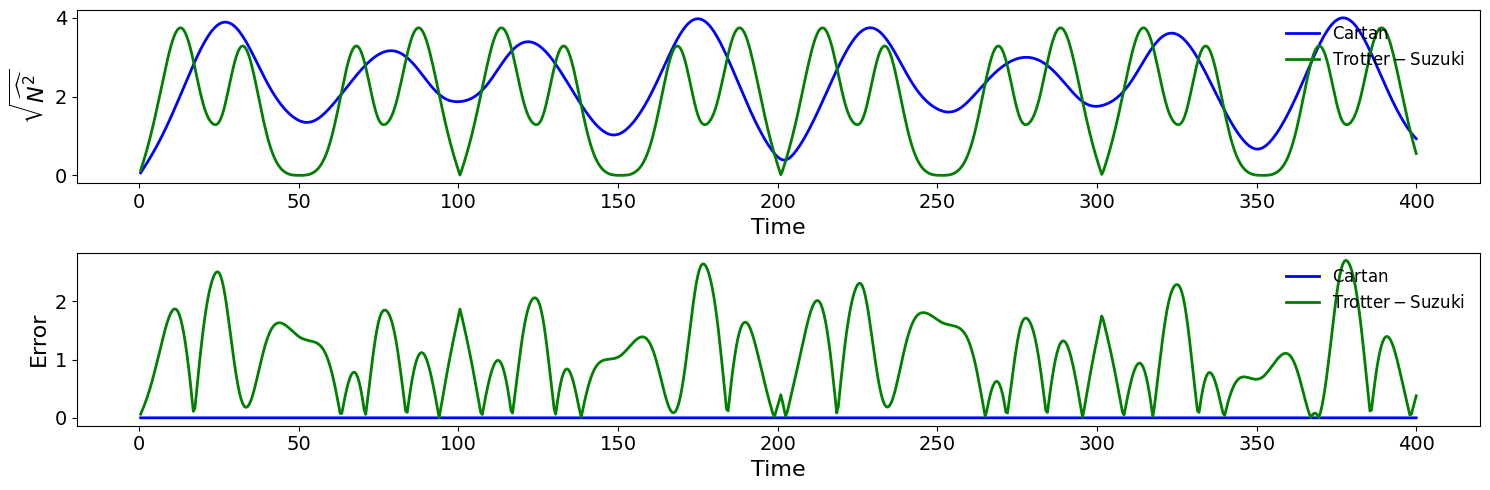

In [13]:
# Create the plot

#plt.style.use('default')
figure, axis = plt.subplots(2, 1, figsize=(15, 5))

# Plots
axis[0].plot(t_values, np.sqrt(ev_cartan), label=r'$\mathrm{Cartan}$',linewidth=2,color='blue')
axis[0].plot(t_values, np.sqrt(ev_trotter), label=r'$\mathrm{Trotter-Suzuki}$',linewidth=2,color='green')

axis[1].plot(t_values, np.abs(np.sqrt(np.real(ev_cartan))-np.sqrt(np.real(ev_exact))), label=r'$\mathrm{Cartan}$',linewidth=2,color='blue')
axis[1].plot(t_values, np.abs(np.sqrt(np.real(ev_trotter))-np.sqrt(np.real(ev_exact))), label=r'$\mathrm{Trotter-Suzuki}$',linewidth=2,color='green')

#Axes label
axis[0].set_xlabel(r'Time', fontsize=16)
axis[0].set_ylabel(r'$\sqrt{\widehat{N^2}}$', fontsize=16)

axis[1].set_xlabel(r'Time', fontsize=16)
axis[1].set_ylabel(r'Error', fontsize=16)

# Ensure y-range starts from 0
#plt.ylim(0, None)

# Add grid
#axis[0].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
#axis[1].grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Legend
axis[0].legend(fontsize=12, loc='upper right', frameon=False, framealpha=0.9, edgecolor='black')
axis[1].legend(fontsize=12, loc='upper right', frameon=False, framealpha=0.9, edgecolor='black')

# Bold ticks
axis[0].tick_params(axis='x', labelsize=14)
axis[0].tick_params(axis='y', labelsize=14)

axis[1].tick_params(axis='x', labelsize=14)
axis[1].tick_params(axis='y', labelsize=14)

# Show the plot
plt.tight_layout()
plt.show()